# Intersection between Ark and Atlas

August 2019, Stephen Strowes, CAIDA / RIPE NCC

The Atlas and Ark both collect topological data, but the platform goals differ, and therefore so do the methods.

Overviews of the datasets are detailed in two other documents (**provide links**).

This document looks at the intersection of these datasets.


In [ ]:
%load_ext google.cloud.bigquery

## IPv6

### Address coverage

In [ ]:
%%bigquery ark_addr_counts

select ts, sum(addr_count) as c
from sds_test.topo_ipv6_ark_target_addrs
group by ts
order by ts

In [16]:
%%bigquery atlas_addr_counts

select ts, sum(addr_count) as c
from sds_test.topo_ipv6_atlas_target_addrs
group by ts
order by ts

### Subnet (/64) coverage

In [13]:
%%bigquery ark_slash64_counts

select ts, sum(addr_count) as c
from sds_test.topo_ipv6_ark_target_subnets
group by ts
order by ts

In [17]:
%%bigquery atlas_slash64_counts

select ts, sum(addr_count) as c
from sds_test.topo_ipv6_atlas_target_subnets
group by ts
order by ts

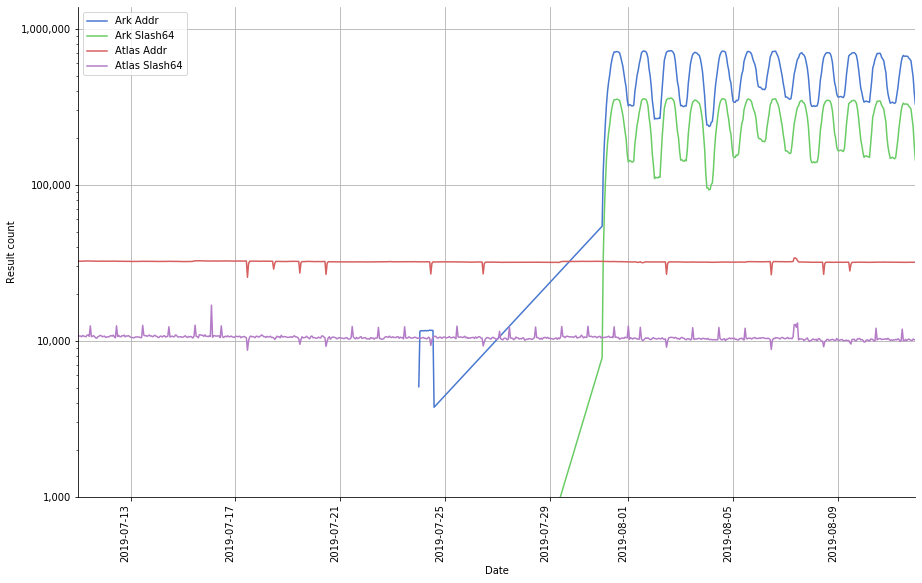

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mplotlib

plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-muted')
#fig, ax = plt.subplots()

ax = ark_addr_counts.plot(kind="line", x="ts", y="c", label="Ark Addr")
ax = ark_slash64_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Ark Slash64")

ax = atlas_addr_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Atlas Addr")
ax = atlas_slash64_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Atlas Slash64")

ax.set_yscale('log')
ax.set_ylabel('Result count')

ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
#plt.box(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')

#plt.show()


In [ ]:
%%bigquery intersection_ip4_ip6_day

WITH ark_ip4s AS (
  SELECT distinct 4 as af, h.hopAddress as ip
  FROM `data-test-194508.caida.ark_traces_ipv4`, UNNEST(hops) as h
  WHERE startTime >= "2019-08-01T00:00:00"
  AND   startTime <  "2019-08-02T00:00:00"
),

ark_ip6s AS (
  SELECT distinct 6 as af, h.hopAddress as ip
  FROM `data-test-194508.caida.ark_traces_ipv6`, UNNEST(hops) as h
  WHERE startTime >= "2019-08-01T00:00:00"
  AND   startTime <  "2019-08-02T00:00:00"
),

atlas_ips AS (
  SELECT af, rh.from as ip
  FROM `data-test-194508.prod.traceroute_atlas_prod`, UNNEST(hops) as h, UNNEST(resultHops) as rh
  WHERE startTime >= "2019-08-01T00:00:00"
  AND   startTime <  "2019-08-02T00:00:00"
),

atlas_ip4s AS (
  SELECT distinct * from atlas_ips WHERE af = 4
),

atlas_ip6s AS (
  SELECT distinct * from atlas_ips WHERE af = 6
)


SELECT *
FROM
  (SELECT count(distinct ip)   as atlas_6_count    from atlas_ip6s),
  (SELECT count(distinct ip)   as ark_6_count      from ark_ip6s),
  (SELECT count(distinct a.ip) as combined_6_count from ark_ip6s a JOIN atlas_ip6s b ON a.ip = b.ip),
  (SELECT count(distinct ip)   as atlas_4_count    from atlas_ip4s),
  (SELECT count(distinct ip)   as ark_4_count      from ark_ip4s),
  (SELECT count(distinct a.ip) as combined_4_count from ark_ip4s a JOIN atlas_ip4s b ON a.ip = b.ip)


In [ ]:
print(intersection_ip4_ip6)

In [ ]:
%%bigquery intersection_ip4_ip6_week

WITH ark_ip4s AS (
  SELECT distinct 4 as af, h.hopAddress as ip
  FROM `data-test-194508.caida.ark_traces_ipv4`, UNNEST(hops) as h
  WHERE startTime >= "2019-08-01T00:00:00"
  AND   startTime <  "2019-08-15T00:00:00"
),

ark_ip6s AS (
  SELECT distinct 6 as af, h.hopAddress as ip
  FROM `data-test-194508.caida.ark_traces_ipv6`, UNNEST(hops) as h
  WHERE startTime >= "2019-08-01T00:00:00"
  AND   startTime <  "2019-08-15T00:00:00"
),

atlas_ips AS (
  SELECT af, rh.from as ip
  FROM `data-test-194508.prod.traceroute_atlas_prod`, UNNEST(hops) as h, UNNEST(resultHops) as rh
  WHERE startTime >= "2019-08-01T00:00:00"
  AND   startTime <  "2019-08-15T00:00:00"
),

atlas_ip4s AS (
  SELECT distinct * from atlas_ips WHERE af = 4
),

atlas_ip6s AS (
  SELECT distinct * from atlas_ips WHERE af = 6
)


SELECT *
FROM
  (SELECT count(distinct ip)   as atlas_6_count    from atlas_ip6s),
  (SELECT count(distinct ip)   as ark_6_count      from ark_ip6s),
  (SELECT count(distinct a.ip) as combined_6_count from ark_ip6s a JOIN atlas_ip6s b ON a.ip = b.ip),
  (SELECT count(distinct ip)   as atlas_4_count    from atlas_ip4s),
  (SELECT count(distinct ip)   as ark_4_count      from ark_ip4s),
  (SELECT count(distinct a.ip) as combined_4_count from ark_ip4s a JOIN atlas_ip4s b ON a.ip = b.ip)
--  (SELECT count(distinct ip) from atlas_ip6s)


## IPv4

### Address Coverage

### Subnet (/24) Coverage

In 1 month of data, looks like:

* 3.5M subnets in Ark data
* 0.6M subnets in Atlas data? (This looks wrong)
* Intersection: 3.7M 

## Dataset Growth

How rapidly do the datasets accumulate addresses, subnets, ASNs?

In [33]:
%%bigquery atlas_slash64_firstseen_counts

select *, SUM(c) OVER(ORDER BY first_seen) as t
from sds_test.topo_ipv6_atlas_target_subnets_firstseen



In [34]:
%%bigquery atlas_addrs_firstseen_counts

select *, SUM(c) OVER(ORDER BY first_seen) as t
from sds_test.topo_ipv6_atlas_target_addrs_firstseen



In [35]:
%%bigquery ark_slash64_firstseen_counts

select *, SUM(c) OVER(ORDER BY first_seen) as t
from sds_test.topo_ipv6_ark_target_subnets_firstseen



In [36]:
%%bigquery ark_addrs_firstseen_counts

select *, SUM(c) OVER(ORDER BY first_seen) as t
from sds_test.topo_ipv6_ark_target_addrs_firstseen


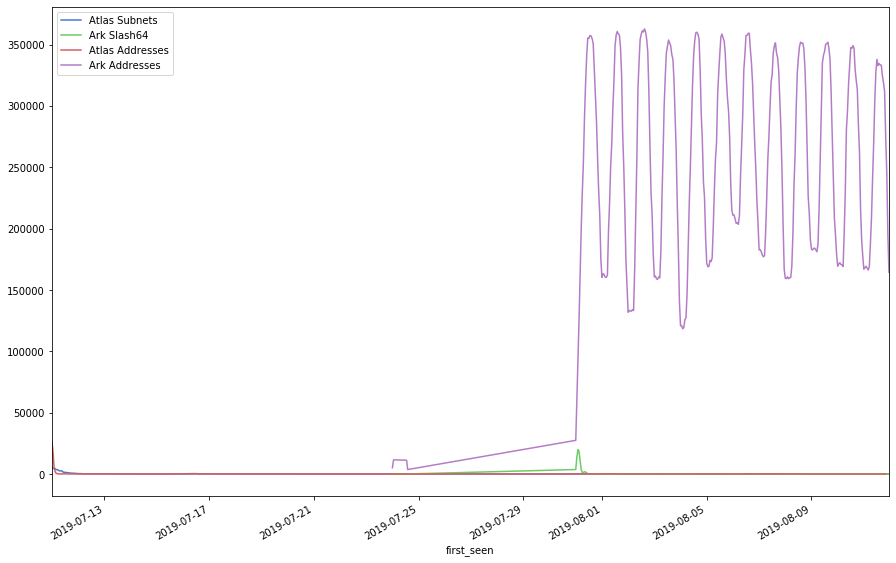

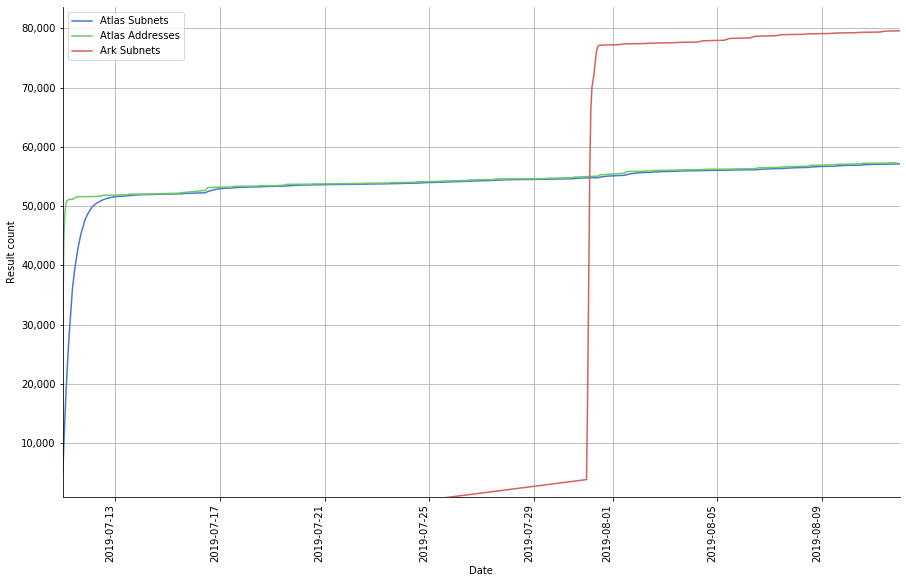

In [68]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mplotlib

plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-muted')
#fig, ax = plt.subplots()

ax = atlas_slash64_firstseen_counts.plot(kind="line", x="first_seen", y="c", label="Atlas Subnets")
ax = ark_slash64_firstseen_counts.plot(ax=ax, kind="line", x="first_seen", y="c", label="Ark Slash64")
ax = atlas_addrs_firstseen_counts.plot(ax=ax, kind="line", x="first_seen", y="c", label="Atlas Addresses")
ax = ark_addrs_firstseen_counts.plot(ax=ax, kind="line", x="first_seen", y="c", label="Ark Addresses")


ax = atlas_slash64_firstseen_counts.plot(kind="line", x="first_seen", y="t", label="Atlas Subnets")
ax = atlas_addrs_firstseen_counts.plot(ax=ax, kind="line", x="first_seen", y="t", label="Atlas Addresses")
ax = ark_slash64_firstseen_counts.plot(ax=ax, kind="line", x="first_seen", y="t", label="Ark Subnets")
#ax = ark_addrs_firstseen_counts.plot(ax=ax, kind="line", x="first_seen", y="t", label="Ark Addresses")



#ax = atlas_addr_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Atlas Addr")
#ax = atlas_slash64_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Atlas Slash64")

#ax.set_yscale('log')
ax.set_ylabel('Result count')

ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
#plt.box(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')





In [47]:
%%bigquery ark_unique_addrs_per_hour

with f as (
  select DATETIME_TRUNC(DATETIME(start_time), HOUR) as ts, fae as addr
  from sds_test.adjacencies_topo_ipv6_ark_20190801, unnest(h)
),
t as (
  select DATETIME_TRUNC(DATETIME(start_time), HOUR) as ts, tae
  from sds_test.adjacencies_topo_ipv6_ark_20190801, unnest(h)
),
combined as (
  select * from f
  union all
  select * from t
)

select ts, count(addr) as c
from combined
group by ts


In [48]:
%%bigquery atlas_unique_addrs_per_hour

with f as (
  select DATETIME_TRUNC(DATETIME(startTime), HOUR) as ts, fae as addr
  from sds_test.adjacencies_topo_ipv6_20190801, unnest(h)
),
t as (
  select DATETIME_TRUNC(DATETIME(startTime), HOUR) as ts, tae
  from sds_test.adjacencies_topo_ipv6_20190801, unnest(h)
),
combined as (
  select * from f
  union all
  select * from t
)

select ts, count(addr) as c
from combined
group by ts


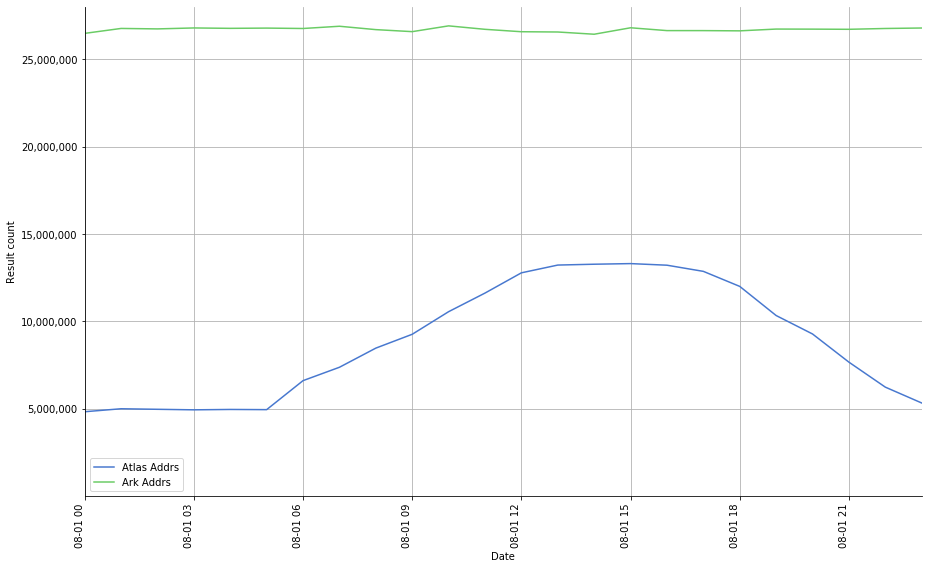

In [49]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mplotlib

plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-muted')
#fig, ax = plt.subplots()

ax = ark_unique_addrs_per_hour.plot(kind="line", x="ts", y="c", label="Atlas Addrs")
ax = atlas_unique_addrs_per_hour.plot(ax=ax, kind="line", x="ts", y="c", label="Ark Addrs")


#ax = atlas_addr_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Atlas Addr")
#ax = atlas_slash64_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Atlas Slash64")

#ax.set_yscale('log')
ax.set_ylabel('Result count')

ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
#plt.box(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')





In [63]:
%%bigquery atlas_unique_addrs_per_hour_2

with addr_counts as (
  select ts, addr, count(addr) as c
  from sds_test.tmp
  where origin = "Atlas"
  group by ts, addr
  order by ts
)

select ts, count(ts) as c
from addr_counts
group by ts
order by ts

In [64]:
%%bigquery ark_unique_addrs_per_hour_2

with addr_counts as (
  select ts, addr, count(addr) as c
  from sds_test.tmp
  where origin = "Ark"
  group by ts, addr
  order by ts
)

select ts, count(ts) as c
from addr_counts
group by ts
order by ts

In [65]:
%%bigquery both_unique_addrs_per_hour_2

with addr_counts as (
  select ts, addr, count(addr) as c
  from sds_test.tmp
  group by ts, addr
  order by ts
)

select ts, count(ts) as c
from addr_counts
group by ts
order by ts


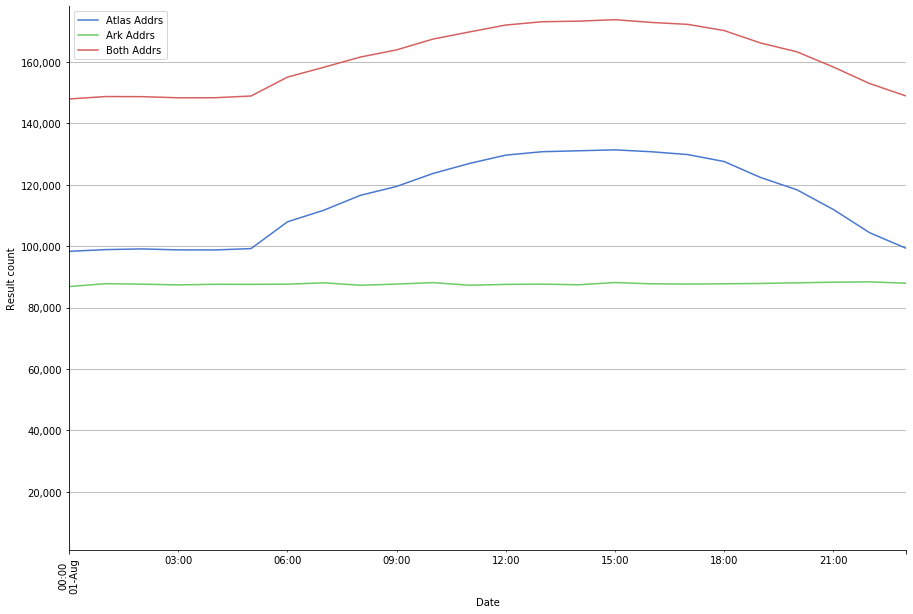

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mplotlib

plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-muted')
#fig, ax = plt.subplots()

ax = ark_unique_addrs_per_hour_2.plot(kind="line", x="ts", y="c", label="Atlas Addrs")
ax = atlas_unique_addrs_per_hour_2.plot(ax=ax, kind="line", x="ts", y="c", label="Ark Addrs")
ax = both_unique_addrs_per_hour_2.plot(ax=ax, kind="line", x="ts", y="c", label="Both Addrs")


#ax = atlas_addr_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Atlas Addr")
#ax = atlas_slash64_counts.plot(ax=ax, kind="line", x="ts", y="c", label="Atlas Slash64")

#ax.set_yscale('log')
ax.set_ylabel('Result count')

ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
#plt.box(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')



